# Examining Hotel Locations in Edinburgh

This project looks at hotel locations in Edinburgh and compares these to the locations of other venues that might be of interest, primarily for tourists but also business visitors and the business community. The hotels are obtained for each postcode area in the city, with the hotels then being clustered according to their geographic location. The centres of each hotel cluster are then used to explorer the nearby venues (excluding hotels). Finally, the clusters of hotels are clustered themselves to look for patterns of venue distribution across the city.

### Setting up the Notebook

Start by importing necessary modules

In [2]:
# import modules

# standard modules for data analysis
import numpy as np
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# sklearn for machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# fastkml to process kml files
from fastkml import kml

# geocoder for obtaining coordinates from an address
import geocoder

# folium for plotting maps
import folium

# requests for handling URL requests
import requests

# json for working with json files
import json

print("Packages imported")

Packages imported


This project will make use of the Foursquare API. It is necessary to define the credentials in order to obtain information from Foursquare.

In [3]:
CLIENT_ID = 'RDWUF4LPXUOYXM3WH3PEEGSK55P1RM5TSIR3ONSMZLWWMRCR' # your Foursquare ID
CLIENT_SECRET = 'LNH1VFG0NMTTYD1TXU3BUHUEBOETPEOZKILKUGAGTYH2PGP0' # your Foursquare Secret
VERSION = '20200529' # Foursquare API version

### Importing postcode data

The first data to be obtained relates to the postal code areas in the Edinburgh City Area. The boundaries of these are available in a .kml file on Wikipedia (https://en.wikipedia.org/wiki/EH_postcode_area). The URL for the data file itself is https://en.wikipedia.org/w/index.php?title=Template:Attached_KML/EH_postcode_area&action=raw .

In [4]:
# Read file into string and convert to UTF-8 (Python3 style)

url = 'https://en.wikipedia.org/w/index.php?title=Template:Attached_KML/EH_postcode_area&action=raw'
kml_file = requests.get(url)

# Grab the content from the webpage
doc=kml_file.content

# Create the KML object to store the parsed result
ed_k = kml.KML()

# Read in the KML string
ed_k.from_string(doc)

# Look at the features
features = list(ed_k.features())

# There is only one feature, the postcode regions. Put this into f1.
f1 = list(features[0].features())

# The details (name, boundaries, centroid etc. of this are contained in the subfeatures)
kml_features = list(f1[0].features())

# kml_features object contains the description of each postcode area in Edinburgh

### Draw a map of Edinburgh and overlay the postal code areas
The kml_features object can be used to plot the postcode regions over a map of Edinburgh. In order to do this, we begin by using geocoder to obtain the coordinates for the city of Edinburgh. We then iterate through the postcode regions in kml_features, using th boundary points to plot each region as a polygon and the centroid to identify each region with a marker.

In [5]:
# get the coordinates of Edinburgh using geocoder

address = 'Edinburgh, United Kingdom'

g = geocoder.arcgis(address)

latitude_ed = g.lat
longitude_ed = g.lng
print('The geographical coordinates of Edinburgh are {}, {}.'.format(latitude_ed, longitude_ed))

The geographical coordinates of Edinburgh are 55.95438000000007, -3.201439999999934.


In [14]:
# Plot a map of Edinburgh and overlay the postcode areas

map_edinburgh = folium.Map(location=[latitude_ed, longitude_ed], zoonSnap=0.25, zoom_start=9.50)

number_of_postcodes=len(kml_features)

print("Imported coordinates of {} postcode areas." .format(number_of_postcodes))

# Create a list to hold information on the postcode regions

postal_regions = []

# iteratue through the regions in kml_features
for kml_region in kml_features:
    
    postcode = kml_region.name
    
    # extract boundary points
    boundary = list(kml_region.geometry.boundary.coords)
    boundary_reversed=[]
    
    # extract centroids
    centre_point = list(kml_region.geometry.centroid.coords)
    centre_point_reversed = []
    
    # the kml file has the latitude and longitude reversed. The following code corrects this 
    
    for item in boundary:
            item=list(item)
            item[1], item[0] = item[0], item[1]
            boundary_reversed.append(item)
    
    for item in centre_point:
        item=list(item)
        item[1], item[0] = item[0], item[1]
        centre_point_reversed.append(item)

    # append the extracted data to the post regions list  
    postal_regions.append([postcode, boundary_reversed, centre_point_reversed[0][0], centre_point_reversed[0][1]])
    
    # define a region based on the boundarz values. This will be plotted on the map
    region = folium.vector_layers.Polygon(boundary_reversed, color='green', weight=2,fill='True')
    
    # define the positions of the markers from the region centroids
    centroid_markers = folium.map.Marker(centre_point_reversed[0], popup=postcode, color='green')

    # add regions and centroids to the map
    map_edinburgh.add_child(region)
    map_edinburgh.add_child(centroid_markers)
    
# generate a dataframe from the postal_regions list
df_postal_regions = pd.DataFrame(postal_regions)
df_postal_regions.columns = ['Postcode', 'Boundary', 'Latitude', 'Longitude']

# save dataframe to csv
df_postal_regions.to_csv('Ed_postcodes.csv')

Imported coordinates of 54 postcode areas.


In [15]:
# Plot the map
map_edinburgh

In [49]:
# display the first 10 postcode regions
df_postal_regions.head(10)

,Postcode,Boundary,Latitude,Longitude
0,EH1,"[[55.95084, -3.19543], [55.95097, -3.19486], [...",55.951314,-3.192052
1,EH2,"[[55.95011, -3.20203], [55.95007, -3.20237], [...",55.952554,-3.200016
2,EH3,"[[55.95778, -3.20884], [55.95794, -3.20876], [...",55.956477,-3.206386
3,EH4,"[[55.96892, -3.23893], [55.96912, -3.23758], [...",55.974482,-3.277853
4,EH5,"[[55.97101, -3.21417], [55.97035, -3.21448], [...",55.992835,-3.238594
5,EH6,"[[55.96678, -3.15386], [55.96671, -3.1544], [5...",55.986275,-3.165328
6,EH7,"[[55.96297, -3.16565], [55.96442, -3.1646], [5...",55.961308,-3.159864
7,EH8,"[[55.94672, -3.16861], [55.94584, -3.17138], [...",55.949503,-3.159124
8,EH9,"[[55.92544, -3.1721], [55.92526, -3.17116], [5...",55.930841,-3.186039
9,EH10,"[[55.91187, -3.2177], [55.91214, -3.21912], [5...",55.902012,-3.209283


This graph nicely shows the 54 postcode regions around the City of Edinburgh. Clicking on the markers reveals the identifier for each. We can now proceed to search for the hotels located within each region.


# Find hotels in the Edinburgh area
Now that the postcode regions have been defined and their centroid coordinates obtained, it is possible to obtain the hotels located within each postcode region using a Foursquare API call using the search endpoint. We can iterate through the postcode regions, using the centroid coordinates as the location data. As we are searching for hotels we can use a query "Hotels". A rather large radius is used to encompass each postcode region. As the radii for the regions might overlap, a check is made that the actually postcode of the hotel is within the specified postcode region to avoid duplication.

In [16]:
def get_venue_cat(postcodes, latitudes, longitudes, query, radius=3500, LIMIT=200):
# function to get vanues of a particular category around a positions 
    
    # list to hold data as we extract it
    venues_list=[]
    
    # iterate through postcodes using their centroid latitudes and longitudes
    for postcode_area, lat, lng in zip(postcodes, latitudes, longitudes):
        
        print('Retrieving {}s from the {} postcode'.format(query, postcode_area))
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            query,
            radius,
            LIMIT)

        # make the GET request
        
        try:     
            results = requests.get(url).json()['response']['venues']
            
        # in case no results are returned, we skip the postcode   
        except:
            continue
        
        # iterate through the returned results
        for v in results:
            
            # extract name, latitude and longitude
            v_name = v['name']
            v_lat = v['location']['lat']
            v_lng = v['location']['lng']
            
            # check if postcode is known. Otherwise assign "unknown"
            try:
                v_postcode = v['location']['postalCode']
            except:
                v_postcode = 'unknown'
                
            # check if address is known. Otherwise assign "unknown"
            try:
                v_address = v['location']['address']
            except:
                v_address = 'unknown'
            
            # check for categories. Depends on number of levels
            try:
                v_category = v['categories'][0]['name']
            except:
                v_category = v['categories']
            
            # check that hotel is in current postcode area. Only store data if this is the case to avoid duplication.
            if postcode_area in v_postcode:
                venues_list.append([postcode_area, v_name, v_category, v_address, v_postcode, v_lat, v_lng])
            
    # Cast list into a dataframe
    df_venues = pd.DataFrame(venues_list)
    df_venues.columns = ['Postcode Area', 'Name', 'Categories', 'Address', 'PostCode', 'Latitude', 'Longitude']
    
    return df_venues


In [23]:
# Use the function "get_venue_cat" to find all hotels in Edinburgh by postcode

edinburgh_hotels = get_venue_cat(postcodes=df_postal_regions['Postcode'],
                                 latitudes=df_postal_regions['Latitude'],
                                 longitudes=df_postal_regions['Longitude'],
                                 query='Hotel'
                                )

# save the resulting dataframe to a .scv file

edinburgh_hotels.to_csv('hotels.csv')




Retrieving Hotels from the EH1 postcode
Retrieving Hotels from the EH2 postcode
Retrieving Hotels from the EH3 postcode
Retrieving Hotels from the EH4 postcode
Retrieving Hotels from the EH5 postcode
Retrieving Hotels from the EH6 postcode
Retrieving Hotels from the EH7 postcode
Retrieving Hotels from the EH8 postcode
Retrieving Hotels from the EH9 postcode
Retrieving Hotels from the EH10 postcode
Retrieving Hotels from the EH11 postcode
Retrieving Hotels from the EH12 postcode
Retrieving Hotels from the EH13 postcode
Retrieving Hotels from the EH14 postcode
Retrieving Hotels from the EH15 postcode
Retrieving Hotels from the EH16 postcode
Retrieving Hotels from the EH17 postcode
Retrieving Hotels from the EH18 postcode
Retrieving Hotels from the EH19 postcode
Retrieving Hotels from the EH20 postcode
Retrieving Hotels from the EH21 postcode
Retrieving Hotels from the EH22 postcode
Retrieving Hotels from the EH23 postcode
Retrieving Hotels from the EH24 postcode
Retrieving Hotels from th

### Exploring the hotels in Edinburgh
We can start by looking at the hotels dataframe and examining the hotel distribution by postcode. This involves grouping the hotels by postcode.

In [24]:
display(edinburgh_hotels.head(5))

print("Foursquare returned {} Hotels".format(edinburgh_hotels.shape[0]))

,Postcode Area,Name,Categories,Address,PostCode,Latitude,Longitude
0,EH1,Apex City of Edinburgh Hotel,Hotel,61 Grassmarket,EH1 2HJ,55.947198,-3.195282
1,EH1,Radisson Collection Royal Mile Hotel,Hotel,1 George IV Bridge,EH1 1AD,55.949031,-3.192676
2,EH1,Apex Grassmarket Hotel,Hotel,31-35 Grassmarket,EH1 2HS,55.947182,-3.196664
3,EH1,Radisson Blu Hotel,Hotel,"80 High Street, The Royal Mile",EH1 1TH,55.950040,-3.186826
4,EH1,Stay Central Hotel,Hotel,139 Cowgate,EH1 1JS,55.948268,-3.190160


Foursquare returned 121 Hotels


In [25]:
# group the hotels by postcode and sum the number of hotels
hotel_postcodes = pd.DataFrame(edinburgh_hotels['Postcode Area'].value_counts())
hotel_postcodes.columns=['Number of Hotels']
hotel_postcodes.index.name='Postcode Area'

print("These are the top 5 postcodes in Edinburgh for hotels")
hotel_postcodes.head()

These are the top 5 postcodes in Edinburgh for hotels


,Number of Hotels
Postcode Area,
EH1,21
EH12,8
EH2,8
EH16,7
EH6,6


Most hotels are in the EH1 postcode regions. This is the city centre so not surprising. We can make a plot of the number of hotels as a function of postcode area.

Text(0, 0.5, 'Postcode Area')

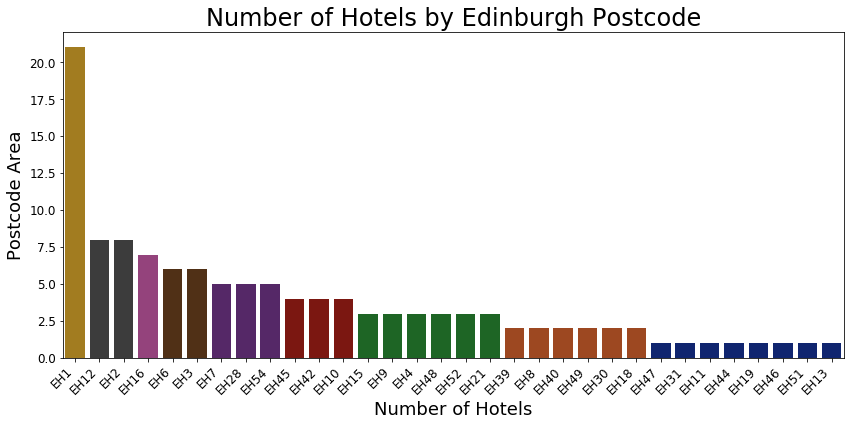

In [26]:
# Define a figure to hold the plot
plt.figure(figsize=(14,6))

# generate the plot using seaborn
postcode_plot = sns.barplot(x=hotel_postcodes.index, y='Number of Hotels', data=hotel_postcodes, hue="Number of Hotels", dodge=False, palette='dark')

# hide unneccesary legend
plt.legend().remove()

# tidy the ticks
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)
plt.yticks( 
    horizontalalignment='right',
    fontsize='large'  
)

# add title and axis labels
postcode_plot.set_title("Number of Hotels by Edinburgh Postcode", fontsize=24)
postcode_plot.set_xlabel("Number of Hotels",fontsize=18)
postcode_plot.set_ylabel("Postcode Area",fontsize=18)


As discussed, clearly, most hotels are located in EH1, which is the Old Town district of Edinburgh. There are other regions with multiple hotels and others with very few hotels. It is useful to look at the distribution of hotels on the map of Edinburgh. We can superpose these over the map of Postcode areas.

In [100]:
# Make a new version of the map of Edinburgh
map_edinburgh_hotels = folium.Map(location=[latitude_ed, longitude_ed], zoom_start=10)

# Add the postcode regions
for pc, bnd in zip(df_postal_regions['Postcode'], df_postal_regions['Boundary']):
    region = folium.vector_layers.Polygon(bnd, color='green', weight=2,fill='True')
    map_edinburgh_hotels.add_child(region)

# define an array of colors we can use as we iterate through the hotels
colors_array = cm.tab20(np.linspace(0, 1, len(hotel_postcodes)))
rainbow = [colors.rgb2hex(i) for i in colors_array]    

# set up variables to track when we have moved onto a new regions
last_pc = []
i=-1

# iterate though the hotels, plotting a circle each time with colour defined by postcode region
for lat, lng, pc, nm in zip(edinburgh_hotels['Latitude'], edinburgh_hotels['Longitude'], edinburgh_hotels['Postcode Area'], edinburgh_hotels['Name']):
    if pc!=last_pc:
        i+=1
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=rainbow[i],
        fill=True,
        popup=nm,
        fill_opacity=1,
        parse_html=False).add_to(map_edinburgh_hotels)
    
    last_pc = pc  

# plot the map with hotels overlayed
map_edinburgh_hotels

Given the large number of hotels in the city centre, grouping by postcode area may not be the best approach. It is likely that the hotels in the city centre are similar in location. We can try using kmeans to cluster the hotels by location using their latitude and latitude.

### Using kmeans to cluster the hotels on location
We will use the kmeans algorithm to cluster the hotels based on their geographic location as defined by the latitude and longitude. To do this we extract the latitude and location values for each hotel and normalize using "StandardScaler". We use kmeans as implemented in SciKit-Learn, iterating through the number of clusters to find the optimum number of clusters. The inertia and silhouette metrics are used to determine the optimum number of clusters for the model.

In [29]:
# define maximum number of clusters
nmax=25

n_k = np.arange(2,nmax+1,1)

In [30]:
# extract the features required - Latitude and Longitude
edinburgh_hotels_loc = edinburgh_hotels[['Latitude', 'Longitude']]

# normalize the values
edinburgh_hotels_loc_norm = StandardScaler().fit_transform(edinburgh_hotels_loc)

# define arrays to hold the calculated intertia and silhuette score
k_means_inertia = []
k_means_silhouette = []

# iterate through the numbers of clusters and append the metrics for each
for n_clusters in n_k:
    hotel_cluster_model = KMeans(n_clusters=n_clusters, random_state=0)
    k_means = hotel_cluster_model.fit(edinburgh_hotels_loc_norm)

    k_means_inertia.append(k_means.inertia_)
    k_means_silhouette.append(metrics.silhouette_score(edinburgh_hotels_loc_norm, k_means.labels_, metric = 'euclidean'))

We can now visualize the models using the metrics by plotting inertia and silhuette score as a function of the number of clusters. 

Text(0, 0.5, 'Inertia')

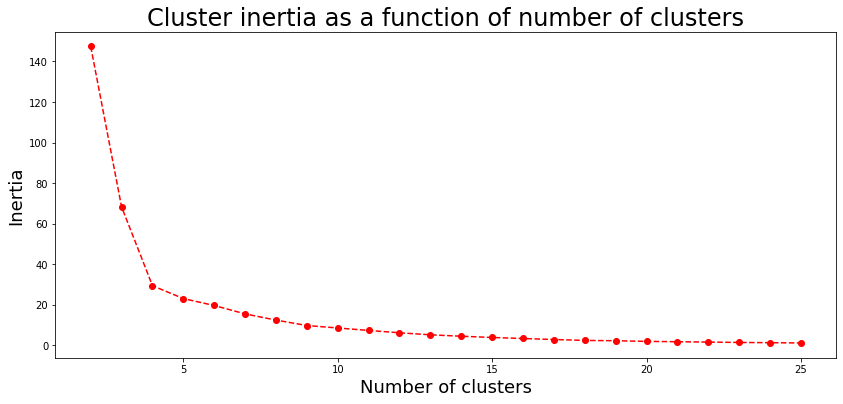

In [31]:
# set up the inertia plot
plt.figure(figsize=(14,6))
plt.plot(n_k, k_means_inertia, color='r', marker='o', linestyle='dashed')

# tidy up the axes
plt.title('Cluster inertia as a function of number of clusters', size=24)
plt.xlabel('Number of clusters', size=18)
plt.ylabel('Inertia', size=18)



The elbow plot for inertia shows a clear change at 4 clusters, but the shape is not so clear to easily define the optimum number of clusters. We can also consider the silhouette score.

Text(0, 0.5, 'Silhuette Score')

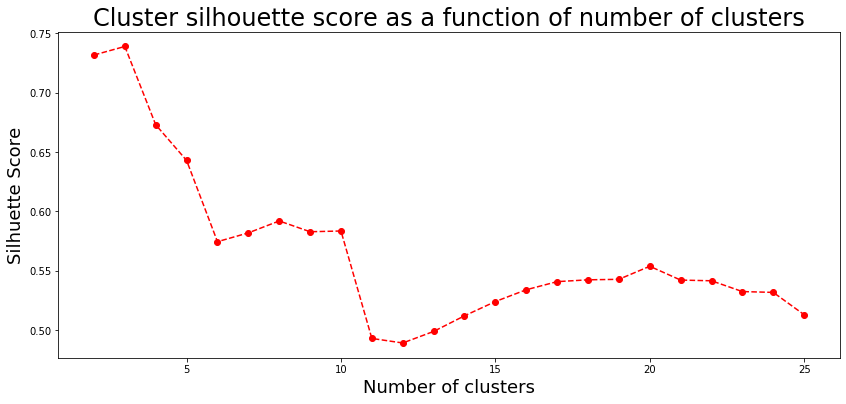

In [32]:
# set up the silhuette score plot
plt.figure(figsize=(14,6))
plt.plot(n_k, k_means_silhouette, color='r', marker='o', linestyle='dashed')

# tidy the axes
plt.title('Cluster silhouette score as a function of number of clusters', size=24)
plt.xlabel('Number of clusters', size=18)
plt.ylabel('Silhuette Score', size=18)

From the silhouette score it seems that we reach 11 clusters before the model converges. Now we can re-fit the model with n_k=11 in order to assign the clusters to the hotels

In [33]:
# define model with optimum number of clusters (11)
hotel_cluster_model = KMeans(n_clusters=11, init='k-means++')

k_means = hotel_cluster_model.fit(edinburgh_hotels_loc_norm)


The cluster labels can now be added to the list of hotels and the hotels re-plotted on the map using their coordinates. We now define the colour of the circle plotted according to the cluster to highlight the cluster distribution. We can also obtain the centroid of each cluster and plot this.

In [36]:
# Asign the cluster labels to the hotels
edinburgh_hotels_clustered = edinburgh_hotels
edinburgh_hotels_clustered['Cluster'] = k_means.labels_

# display the top of the clustered hotels dataframe
edinburgh_hotels_clustered.head()


,Postcode Area,Name,Categories,Address,PostCode,Latitude,Longitude,Cluster
0,EH1,Apex City of Edinburgh Hotel,Hotel,61 Grassmarket,EH1 2HJ,55.947198,-3.195282,0
1,EH1,Radisson Collection Royal Mile Hotel,Hotel,1 George IV Bridge,EH1 1AD,55.949031,-3.192676,0
2,EH1,Apex Grassmarket Hotel,Hotel,31-35 Grassmarket,EH1 2HS,55.947182,-3.196664,0
3,EH1,Radisson Blu Hotel,Hotel,"80 High Street, The Royal Mile",EH1 1TH,55.950040,-3.186826,0
4,EH1,Stay Central Hotel,Hotel,139 Cowgate,EH1 1JS,55.948268,-3.190160,0


We can now plot the hotels by cluster on the map of Edinburgh. In addition to plotting the hotels themselves, we can also plot the centre of each cluster.

In [38]:
# Find the mean latitude and longitude of each hotel cluster.
hotel_clusters = edinburgh_hotels_clustered.groupby('Cluster').mean()

# display clusters dataframe
hotel_clusters

,Latitude,Longitude
Cluster,,
0,55.950166,-3.198208
1,55.996219,-2.562977
2,55.645380,-3.160983
3,55.901795,-3.516069
4,55.895996,-3.152021
5,55.988384,-3.606645
6,55.946615,-3.369685
7,55.753883,-3.356618
8,56.053347,-2.763430


In [99]:
# Make a new version of the map of Edinburgh
map_edinburgh_hotels_clustered = folium.Map(location=[latitude_ed, longitude_ed], zoom_start=10)

# define colours based on number of clusters
colors_array = cm.tab20(np.linspace(0, 1, 11))
rainbow = [colors.rgb2hex(i) for i in colors_array]    

# add hotels to map coloured by cluster number
for lat, lng, nm, clus in zip(edinburgh_hotels_clustered['Latitude'], 
                        edinburgh_hotels_clustered['Longitude'], 
                        edinburgh_hotels_clustered['Name'], 
                        edinburgh_hotels_clustered['Cluster']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=rainbow[clus],
        fill=True,
        popup=nm,
        fill_opacity=1,
        parse_html=False).add_to(map_edinburgh_hotels_clustered)
    
    
# add markers to cluster centres using the cluster means

for n, lat, lng in zip(hotel_clusters.index, hotel_clusters['Latitude'], hotel_clusters['Longitude']):
    folium.map.Marker((lat, lng), popup="Cluster "+str(n),  icon = folium.Icon(color='green', icon='home')).add_to(map_edinburgh_hotels_clustered)

map_edinburgh_hotels_clustered

This map clearly shows the hotel clusters. The largest cluster, in terms of number of hotels, is in the city centre. The other clusters are centred close to particular locations, for example the airport or towns in the area. It is noticeable that there are clusters located in the popular coastal resorts of North Berwick and Dunbar, as well as Peebles in the Pentland Hills which is popular with hikers.

### Examining the hotel neighborhoods

We can use the hotel cluster centroids to determine the venues within 3 km of the centre of each hotel cluster. We now use the FoureSquare API with the explore endpoint, defining a radius of 3000 m. We exclude venues containing the term "Hotel" as we are interested in the venues located nearby hotels.

In [76]:
# define a function to exectute a foursquare explore call

def get_venue_location(cluster, latitudes, longitudes, radius=3000, LIMIT=200):
# function to get all within 3 km of a particular position 
    
    # define a list to hold the venue information
    venues_list=[]
    
    # itaerate through the clusters, taking the centroid latitude and longitude to define the explore location
    for clus, lat, lng in zip(cluster, latitudes, longitudes):
        # create the API request URL
        
        print('Retrieving venues for cluster {}'.format(clus))
        
        # url based on the explore endpoint
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius,
            LIMIT)

        # make the GET request
        try:     
            results = requests.get(url).json()['response']['groups'][0]['items']
        
        # account for the possibility of no results
        except:
            print('No results found')
            continue
        
        #iterate through returned venues    
        for v in results:
            
            # get the names and locations of each venue
            v_name = v['venue']['name']
            v_lat = v['venue']['location']['lat']
            v_lng = v['venue']['location']['lng']
            
            # get the categories of each venue
            try:
                v_category = v['venue']['categories'][0]['name']
               
            except:
                v_category = v['venue']['categories']
            
            # only add the venue to the list of it is not a hotel
            if 'Hotel' not in v_category:
                if 'Hostel' not in v_category:
                    if 'Bed ' not in v_category:
                        venues_list.append([clus, v_name, v_category, v_lat, v_lng])
            
    # Cast list into a dataframe
    df_venues = pd.DataFrame(venues_list)
    df_venues.columns = ['Cluster', 'Name', 'Category', 'Latitude', 'Longitude']
    
    return df_venues



We can now use the function define above to return the venues for each cluster

In [78]:
# obtain venues for each cluster
cluster_venues = get_venue_location(hotel_clusters.index, hotel_clusters['Latitude'], hotel_clusters['Longitude'])

cluster_venues.to_csv('venues.csv')

Retrieving venues for cluster 0
Retrieving venues for cluster 1
Retrieving venues for cluster 2
Retrieving venues for cluster 3
Retrieving venues for cluster 4
Retrieving venues for cluster 5
Retrieving venues for cluster 6
Retrieving venues for cluster 7
Retrieving venues for cluster 8
Retrieving venues for cluster 9
Retrieving venues for cluster 10


In [79]:
# display top of the cluster venues dataframe
display(cluster_venues.head(10))

print('Found details on {} venues in Edinburgh.'.format(len(cluster_venues)))

,Cluster,Name,Category,Latitude,Longitude
0,0,West Princes Street Gardens,Park,55.951042,-3.199393
1,0,Edinburgh Castle,Castle,55.948815,-3.200283
2,0,Old Town,Neighborhood,55.949500,-3.192805
3,0,Castlehill,Scenic Lookout,55.948811,-3.196581
4,0,Whiski Rooms,Scottish Restaurant,55.950015,-3.193522
5,0,Oink,Sandwich Place,55.948592,-3.194099
6,0,Castello Coffee Co,Coffee Shop,55.951192,-3.202808
7,0,Mary's Milk Bar,Ice Cream Shop,55.947062,-3.197525
8,0,Dishoom,Indian Restaurant,55.953726,-3.192540
9,0,The Bon Vivant,Cocktail Bar,55.953953,-3.199726


Found details on 397 venues in Edinburgh.


We can now group the venues and hotels by cluster to examine the number of each per cluster. We can also plot these to look for any correlation.

In [80]:
# group the results by cluster to get the number of venues in each

venue_counts = cluster_venues.groupby('Cluster').count()[["Name"]].rename(
                                   columns={'Name':'Number of venues returned'}).sort_values(
                                   'Number of venues returned', ascending=False)
# do the same for the hotels

hotel_counts = edinburgh_hotels_clustered.groupby('Cluster').count()[['Name']].rename(
                                   columns={'Name':'Number of hotels returned'}).sort_values(
                                   'Number of hotels returned', ascending=False)

# combine the number of venues and hotels for each cluster
clusters_venues_hotels = pd.concat([venue_counts, hotel_counts], axis=1)

# display the dataframe
display(clusters_venues_hotels)

,Number of venues returned,Number of hotels returned
Cluster,,
0,95,68
1,9,6
2,10,5
3,72,7
4,37,6
5,21,3
6,34,12
7,4,1
8,23,3


Text(0, 0.5, 'Number')

<Figure size 432x288 with 0 Axes>

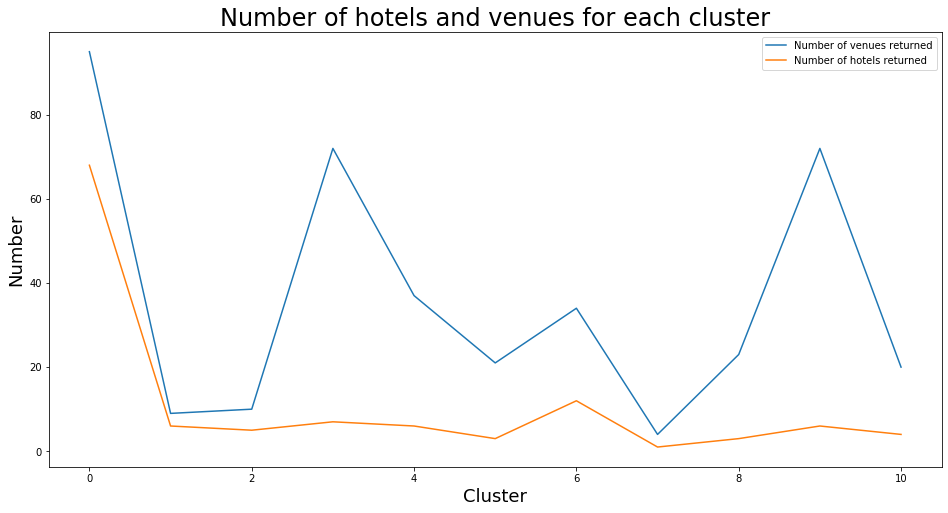

In [81]:
# plot the number of hotels and venues for each cluster
plt.figure()

clusters_plot = clusters_venues_hotels.plot.line(figsize=(16,8))
plt.title('Number of hotels and venues for each cluster', size=24)
plt.xlabel('Cluster', size=18)
plt.ylabel('Number', size=18)

As might expected, there appears to be a correlation beteen number of hotels and number of venues. Let's make a correlation plot to check this

Text(0, 0.5, 'Number of hotels')

<Figure size 432x288 with 0 Axes>

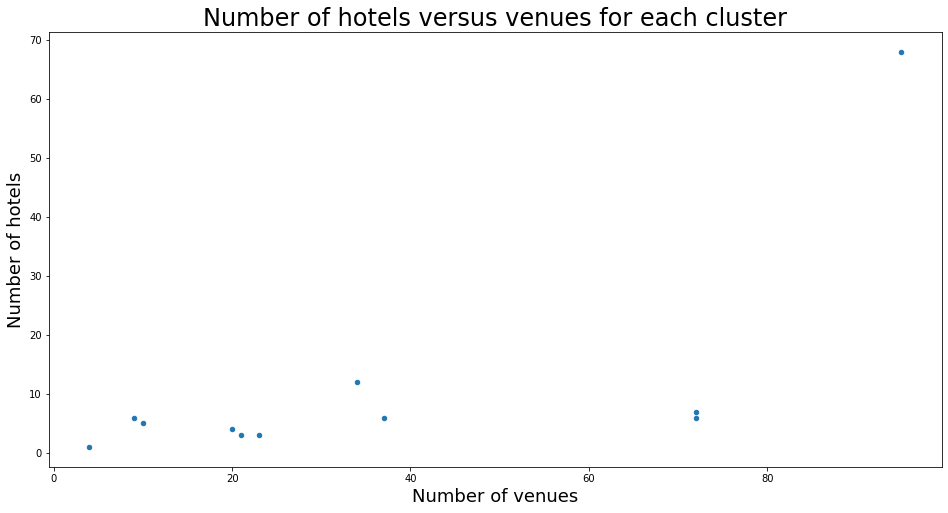

In [82]:
# plot number of hotels versus number of venues for each cluster
plt.figure()

clusters_cor_plot = clusters_venues_hotels.plot.scatter(x='Number of venues returned', y='Number of hotels returned', figsize=(16,8))
plt.title('Number of hotels versus venues for each cluster', size=24)
plt.xlabel('Number of venues', size=18)
plt.ylabel('Number of hotels', size=18)

There certainly seem to be most hotels where there are a lot of venues, so these areas look like a good place to choose a hotel.

### Comparing the hotel clusters

We can use kmeans clustering to compare the hotel clusters and look for similarities based on the venues in each. We use one hot coding the define define the venues located within each cluster, normalize and use kmeans as before.

In [83]:
# remind ourselves of the cluster venues dataframe
cluster_venues.head()

,Cluster,Name,Category,Latitude,Longitude
0,0,West Princes Street Gardens,Park,55.951042,-3.199393
1,0,Edinburgh Castle,Castle,55.948815,-3.200283
2,0,Old Town,Neighborhood,55.949500,-3.192805
3,0,Castlehill,Scenic Lookout,55.948811,-3.196581
4,0,Whiski Rooms,Scottish Restaurant,55.950015,-3.193522


In [84]:
# one hot encoding
edinburgh_onehot = pd.get_dummies(cluster_venues[['Category']], prefix="", prefix_sep="")

# add cluster column dataframe
edinburgh_onehot.insert(0, 'Cluster', cluster_venues['Cluster'])

# now group by cluster to define the overall features for each cluster
edinburgh_onehot_grouped = edinburgh_onehot.groupby('Cluster').mean().reset_index()

# display the dataframe
edinburgh_onehot_grouped

,Cluster,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Toy / Game Store,Trail,Train Station,Tram Station,Video Game Store,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Zoo
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.031579,0.000000,0.000000,0.000000,...,0.000000,0.010526,0.000000,0.000000,0.000000,0.000000,0.000000,0.010526,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.013889,0.000000,0.013889,0.013889,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.013889,0.027778,0.000000,0.000000,0.000000,0.013889
4,4,0.000000,0.000000,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000
5,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000
6,6,0.029412,0.058824,0.029412,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.088235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000
9,9,0.000000,0.000000,0.000000,0.000000,0.013889,0.000000,0.013889,0.000000,0.013889,...,0.013889,0.000000,0.013889,0.000000,0.013889,0.013889,0.013889,0.000000,0.000000,0.000000


Now that the venue category features are defined for each venue we can determine the 5 most common venues for each cluster

In [85]:
# We can examine the 5 most common venues in each cluster
data=[]

# define top n values
num_top_venues = 5

# iterate throough the venues adding the top n venues to a list
for val in edinburgh_onehot_grouped['Cluster']:
    temp = edinburgh_onehot_grouped[edinburgh_onehot_grouped['Cluster'] == val].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    data.append((temp.sort_values('freq', ascending=False).reset_index(drop=True)['venue'].head(num_top_venues)).values.tolist())  

# cast the list as a dataframe
cluster_top_venues = pd.DataFrame(data)

# rename columns according to number of top venues
indicators = ['st', 'nd', 'rd']

for ind in np.arange(num_top_venues):

    try:
        cluster_top_venues.rename(columns={ind: '{}{} Most Common Venue'.format(ind+1, indicators[ind])}, inplace=True)
    except:
        cluster_top_venues.rename(columns={ind: '{}th Most Common Venue'.format(ind+1)}, inplace=True)

# add in the clusters columns
cluster_top_venues = pd.concat([edinburgh_onehot_grouped['Cluster'], cluster_top_venues, hotel_clusters['Latitude'], hotel_clusters['Longitude']], axis=1)


In [86]:
# display the dataframe of most common venues
cluster_top_venues

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
0,0,Park,Coffee Shop,Café,Beer Bar,Cocktail Bar,55.950166,-3.198208
1,1,Farm,Surf Spot,Grocery Store,Park,Fish & Chips Shop,55.996219,-2.562977
2,2,Café,Trail,Pizza Place,Forest,Gastropub,55.645380,-3.160983
3,3,Supermarket,Coffee Shop,Pub,Grocery Store,Clothing Store,55.901795,-3.516069
4,4,Supermarket,Fast Food Restaurant,Pub,Furniture / Home Store,Clothing Store,55.895996,-3.152021
5,5,Supermarket,Pub,Gym / Fitness Center,Sandwich Place,Gastropub,55.988384,-3.606645
6,6,Tram Station,Rental Car Location,Pub,Airport Lounge,Donut Shop,55.946615,-3.369685
7,7,Construction & Landscaping,Steakhouse,Pub,Grocery Store,Rental Car Location,55.753883,-3.356618
8,8,Restaurant,Pub,Coffee Shop,Golf Course,Mountain,56.053347,-2.763430
9,9,Clothing Store,Coffee Shop,Pub,Fast Food Restaurant,Park,55.935636,-3.076713


We now find the optimum number of clusters of clusters to see if there is any difference to the hotel clusters when we consider the venues types in each.

In [87]:
# define maximum number of clusters
nmax=10

n_k = np.arange(2,nmax+1, 1)



In [89]:
# perform the kmeans clustering in the same way as before
edinburgh_clusters_clustering = edinburgh_onehot_grouped.drop('Cluster', 1)

edinburgh_clusters_clustering_norm = StandardScaler().fit_transform(edinburgh_clusters_clustering)

# define array to hold the calculated intertia
k_means_inertia = []
k_means_silhouette = []

for n_clusters in n_k:
    clusters_cluster_model = KMeans(n_clusters=n_clusters, random_state=0)
    k_means = clusters_cluster_model.fit(edinburgh_clusters_clustering_norm)

    k_means_inertia.append(k_means.inertia_)
    k_means_silhouette.append(metrics.silhouette_score(edinburgh_clusters_clustering_norm, k_means.labels_, metric = 'euclidean'))

Text(0, 0.5, 'Inertia')

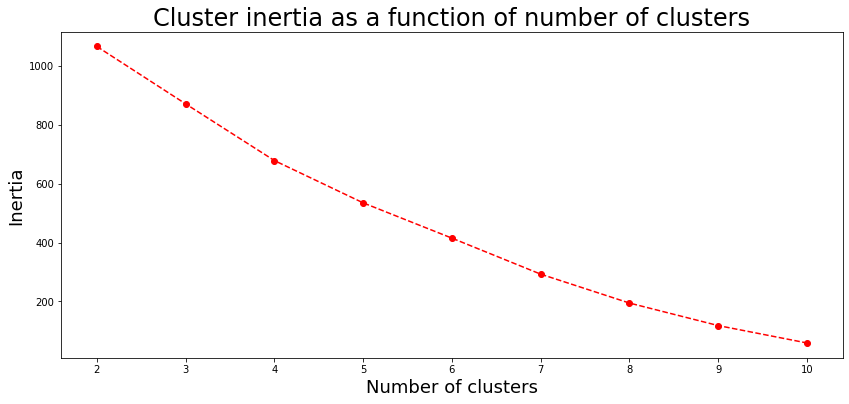

In [90]:
# plot the inertia metric
plt.figure(figsize=(14,6))
plt.plot(n_k, k_means_inertia, color='r', marker='o', linestyle='dashed')

plt.title('Cluster inertia as a function of number of clusters', size=24)
plt.xlabel('Number of clusters', size=18)
plt.ylabel('Inertia', size=18)

There is not clear elbow in the inertia plot which suggests that the hotel clusters are already a reasonable description of the venues.

Text(0, 0.5, 'Silhuette Score')

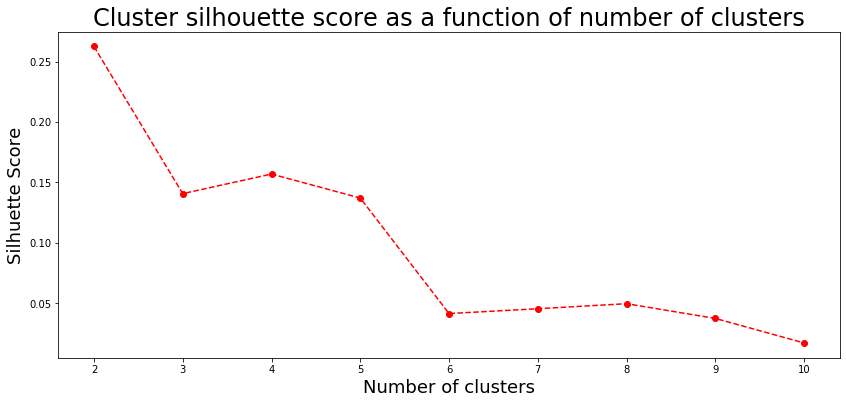

In [35]:
plt.figure(figsize=(14,6))
plt.plot(n_k, k_means_silhouette, color='r', marker='o', linestyle='dashed')

plt.title('Cluster silhouette score as a function of number of clusters', size=24)
plt.xlabel('Number of clusters', size=18)
plt.ylabel('Silhuette Score', size=18)

However, the silhuette score reveals that there are actually 6 clusters which means that some of the hotel clusters are similar in terms of venues. Let's define 6 as the number of clusters and examine.

In [94]:
clusters_cluster_model = KMeans(n_clusters=6, random_state=0)
k_means = clusters_cluster_model.fit(edinburgh_clusters_clustering_norm)

# add the venues cluster number to the top venues table
cluster_top_venues['Venues Cluster'] = k_means.labels_

In [95]:
cluster_top_venues

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude,Venues Cluster
0,0,Park,Coffee Shop,Café,Beer Bar,Cocktail Bar,55.950166,-3.198208,2
1,1,Farm,Surf Spot,Grocery Store,Park,Fish & Chips Shop,55.996219,-2.562977,4
2,2,Café,Trail,Pizza Place,Forest,Gastropub,55.645380,-3.160983,4
3,3,Supermarket,Coffee Shop,Pub,Grocery Store,Clothing Store,55.901795,-3.516069,0
4,4,Supermarket,Fast Food Restaurant,Pub,Furniture / Home Store,Clothing Store,55.895996,-3.152021,1
5,5,Supermarket,Pub,Gym / Fitness Center,Sandwich Place,Gastropub,55.988384,-3.606645,1
6,6,Tram Station,Rental Car Location,Pub,Airport Lounge,Donut Shop,55.946615,-3.369685,3
7,7,Construction & Landscaping,Steakhouse,Pub,Grocery Store,Rental Car Location,55.753883,-3.356618,4
8,8,Restaurant,Pub,Coffee Shop,Golf Course,Mountain,56.053347,-2.763430,4
9,9,Clothing Store,Coffee Shop,Pub,Fast Food Restaurant,Park,55.935636,-3.076713,5


Finally, we can view the hotels on the map colorcoded by hotel cluster and venues cluster

In [96]:
# Make a new version of the map of Edinburgh
final_map = folium.Map(location=[latitude_ed, longitude_ed], zoom_start=10)

# define colours
colors_array = cm.tab20(np.linspace(0, 1, 11))
colors_array2 = cm.tab20(np.linspace(0, 1, 8))
rainbow = [colors.rgb2hex(i) for i in colors_array]    
rainbow2 = [colors.rgb2hex(i) for i in colors_array2] 

# add hotels to map
for lat, lng, nm, clus, in zip(edinburgh_hotels_clustered['Latitude'], 
                        edinburgh_hotels_clustered['Longitude'], 
                        edinburgh_hotels_clustered['Name'], 
                        edinburgh_hotels_clustered['Cluster']):
    
    ven_clus=(int(cluster_top_venues.loc[cluster_top_venues['Cluster']==clus]['Venues Cluster']))

    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color=rainbow[clus],
        fill_color=rainbow2[ven_clus],
        popup=nm,
        tooltip=ven_clus,
        fill_opacity=1,
        parse_html=False).add_to(final_map)
    
    
#add markers to cluster centres

for n, lat, lng in zip(hotel_clusters.index, hotel_clusters['Latitude'], hotel_clusters['Longitude']):
    folium.map.Marker((lat, lng), popup="Cluster "+str(n),  icon = folium.Icon(color='green', icon='home')).add_to(final_map)

final_map

The clustering clearly shows that while some hotel clusters are geographically distinct, they are similar when taking into account the venues. For example, the towns in the Pentland hills and around the coast a somewhat similar. Likewise the out of town locations to the west of Edinburgh show some similarity.